In [2]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')

In [3]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.rolling_factor_analysis import RollingFactorAnalysis
from financial_common.risk.single_index_capm import SingleIndexCAPM
from financial_common.indicator.indicator import Indicator
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.kpi import KPI
from financial_common.metric.metric import Metric
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
from financial_common.risk.risk_type import RiskType
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [4]:
## Import standard packages
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [5]:
market = ADatabase("market")
fred = ADatabase("fred")
orivault = ADatabase("ori")

In [6]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("index")
market.disconnect()

In [7]:
## Defining Benchmark
market.connect()
benchmark = market.query("prices",{"ticker":"JPM"})
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"adjclose")

In [86]:
rolling_window = 20
market.connect()
prices = []
for ticker in tqdm(index["ticker"]): 
    try:
        price = market.query("prices", {"ticker": ticker})
        if price.index.size > 150:
            price = p.lower_column(price)
            price = p.utc_date(price)
            price.sort_values("date", inplace=True)
            price = p.additional_date_columns(price)
            for member in Metric:
                price = member.calculate(price,timeframe=rolling_window)
            for member in Indicator:
                price = member.calculate(price,timeframe=rolling_window)
            for member in RiskType:
                price = member.apply(price)
            prices.append(price.dropna())
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11261/11261 [02:38<00:00, 71.24it/s]


In [118]:
simulation.drop(["ticker","date"],axis=1).corr().sort_values("optimal")[["optimal"]]

,optimal
quarter,-0.022150
month,-0.017017
week,-0.016719
bollinger_lower,-0.012142
ema_corr,-0.010967
volume,-0.008878
williams_r,-0.007698
rolling_dollar_volume,-0.005618
momentum,-0.002725
distance,-0.001978


In [262]:
portfolios = PortfolioSelection.generate_possible_portfolios(ranking_metrics=["sma"],num_of_groups=[5,10])
filtered_portfolios = []
for portfolio in portfolios:
        if portfolio.timeframe.value == "week" and portfolio.grouping_type.value == "standard_dev" and portfolio.allocation_type.label == "equal":
            portfolio.stoploss = 0.1
            filtered_portfolios.append(portfolio)
len(filtered_portfolios)

16

In [87]:
model_end = 2020
backtest_end = 2026
simulation = pd.concat(prices)
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)]
simulation.sort_values("date", inplace=True)

In [274]:
analysises = []
for min_price in tqdm([1,5,10]):
    for max_price in tqdm([5,10,100]):
        filtered_simulation = simulation[(simulation["adjclose"]<=max_price) & (simulation["adjclose"]>=min_price)].copy()
        if filtered_simulation.index.size > 0:
            for portfolio in filtered_portfolios:
                try:
                    trades = portfolio.trades(filtered_simulation.copy())
                    performance = portfolio.portfolio(trades.copy(),benchmark.copy())
                    metrics = KPI.performance(trades,performance)
                    results = {**portfolio.to_dict(),**metrics.copy()}
                    results["portfolio"] = portfolio
                    results["rolling_window"] = rolling_window
                    results["max_price"] = max_price
                    results["min_price"] = min_price
                    analysises.append(results)
                except Exception as e:
                    print(str(e))
                    continue

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:43<00:00, 74.57s/it]


In [275]:
a = pd.DataFrame(analysises)

In [285]:
metric = "raw_pnl"
filtered_a = a.drop(["date","risk_type","timeframe","allocation_type","selection_percentage"],axis=1).sort_values(metric,ascending=False)
top = a.sort_values(metric,ascending=False).head(20).to_dict("records")[0]
filtered_a.head(20)

,ranking_metric,position_type,grouping_type,selection_type,stoploss,num_of_groups,pnl,raw_pnl,downside,coefficient_of_variation,...,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,portfolio,rolling_window,max_price,min_price,color,return_to_risk
42,sma,short,STANDARD_DEV,bottom,0.1,5,163350.207437,208095.432544,0.927498,5.349945,...,0.927821,0.611618,1.052872,5.349849,<financial_common.portfolio_management.portfol...,20,100,1,red,5.349945
44,sma,long,STANDARD_DEV,long_short,0.1,5,8190.558081,31851.059210,0.931701,5.062786,...,0.931899,0.546058,1.039072,5.060973,<financial_common.portfolio_management.portfol...,20,100,1,green,5.062786
43,sma,short,STANDARD_DEV,bottom,0.1,10,7825.350364,10118.393811,0.928997,5.281210,...,0.930104,0.586307,1.038939,5.279230,<financial_common.portfolio_management.portfol...,20,100,1,red,5.281210
34,sma,short,STANDARD_DEV,mixed,0.1,5,2942.976987,3877.335678,0.917889,4.939731,...,0.930099,0.586722,1.034639,4.934806,<financial_common.portfolio_management.portfol...,20,100,1,green,4.939731
45,sma,long,STANDARD_DEV,long_short,0.1,10,1359.038957,3741.071747,0.963550,4.921872,...,0.934295,0.539419,1.030907,4.911246,<financial_common.portfolio_management.portfol...,20,100,1,green,4.921872
36,sma,long,STANDARD_DEV,top,0.1,5,461.985624,2034.847011,0.912870,4.500791,...,0.934947,0.480498,1.028869,4.472192,<financial_common.portfolio_management.portfol...,20,100,1,blue,4.500791
26,sma,short,STANDARD_DEV,bottom,0.1,5,1432.840497,1929.763498,0.930631,4.479020,...,0.933234,0.604149,1.031695,4.469843,<financial_common.portfolio_management.portfol...,20,10,1,red,4.479020
28,sma,long,STANDARD_DEV,long_short,0.1,5,587.935423,1721.700548,0.945851,4.154091,...,0.937142,0.566390,1.027490,4.133350,<financial_common.portfolio_management.portfol...,20,10,1,green,4.154091
37,sma,long,STANDARD_DEV,top,0.1,10,228.676549,870.900530,0.909652,4.399973,...,0.937712,0.492531,1.024390,4.343489,<financial_common.portfolio_management.portfol...,20,100,1,blue,4.399973
20,sma,long,STANDARD_DEV,top,0.1,5,258.136202,822.886874,0.904483,3.767043,...,0.940423,0.528631,1.025650,3.724291,<financial_common.portfolio_management.portfol...,20,10,1,blue,3.767043


In [286]:
# orivault.cloud_connect()
# orivault.drop("results")
# orivault.store("results",pd.DataFrame([top]).drop("portfolio",axis=1))
# orivault.disconnect()

In [287]:
a["color"] = ["blue" if x == "top" else "red" if x == "bottom"  else "green" for x in a["selection_type"]]
a["return_to_risk"] = a["pnl"] / a["portfolio_std"]

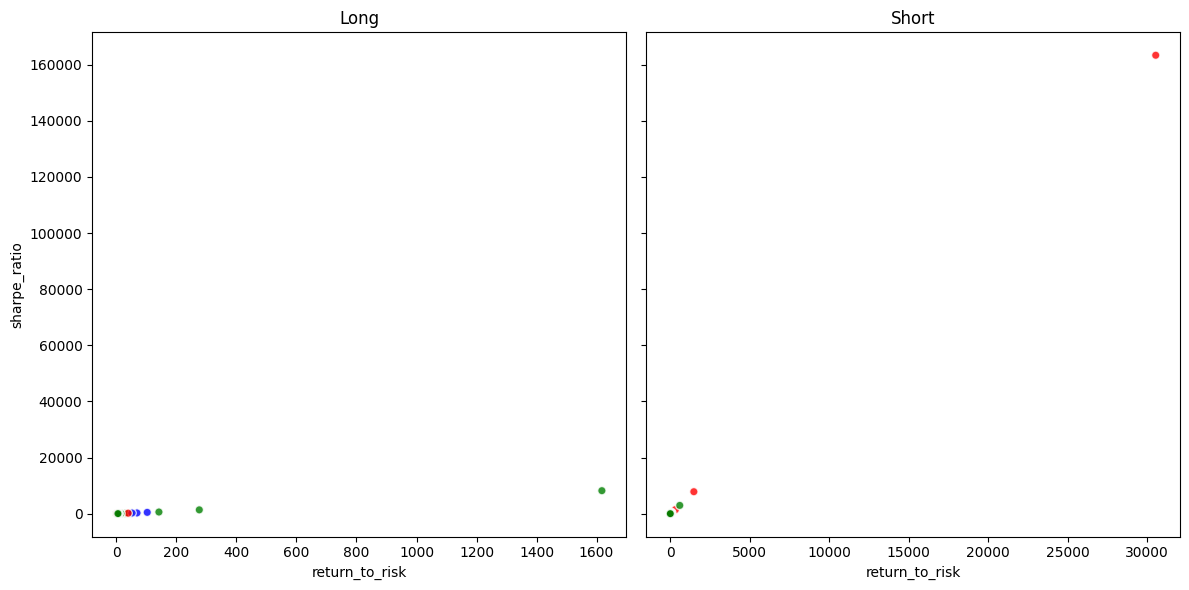

In [288]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Long", "Short"]

# Iterate over directions and corresponding axes
for i, position_type in enumerate(["long", "short"]):
    d_analysis = a[a["position_type"] == position_type]
    axes[i].scatter(
        d_analysis["portfolio_std"],
        d_analysis["pnl"],
        c=d_analysis["color"],
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("return_to_risk")
    axes[i].set_ylabel("sharpe_ratio" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [289]:
pm = top["portfolio"]
filtered_simulation = simulation[(simulation["adjclose"]<=top["max_price"]) & (simulation["adjclose"]>=top["min_price"])]
trades = pm.trades(filtered_simulation.copy())
trades = p.additional_date_columns(trades)
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)

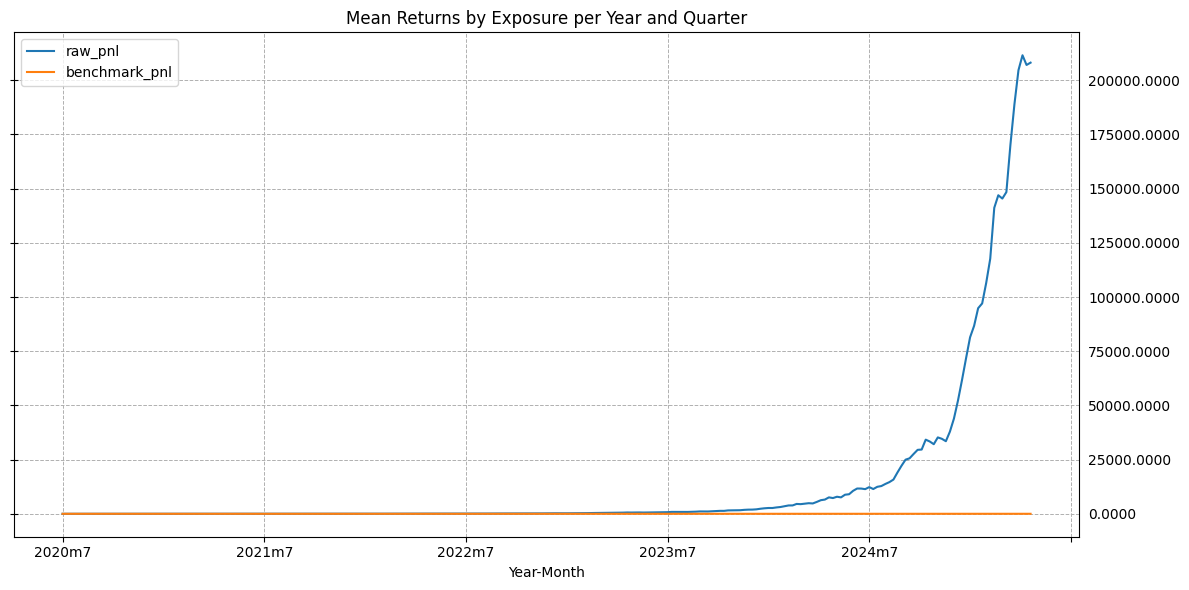

In [290]:
portfolio['Year-Month'] = portfolio["year"].astype(str) + "m" + portfolio["month"].astype(str)
ax = portfolio[["Year-Month","raw_pnl","benchmark_pnl"]].set_index("Year-Month").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [291]:
trades[["group_percentile","return"]].groupby("group_percentile").mean().sort_values("return",ascending=False)

,return
group_percentile,
1,1.090530
2,1.067347
3,1.037925
4,1.037133
5,1.031424


In [292]:
len(filtered_simulation["ticker"].unique())

3965

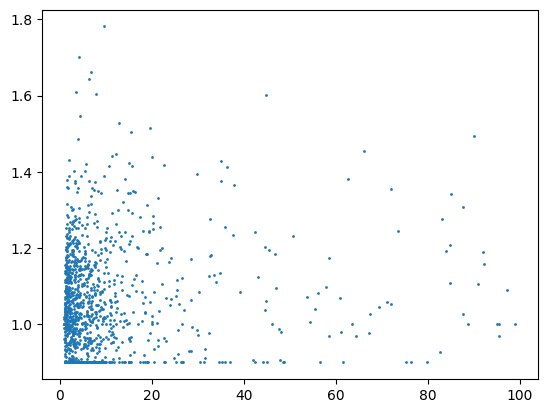

In [293]:
plt.scatter(trades["adjclose"],trades["weighted_return"],s=1)
plt.show()

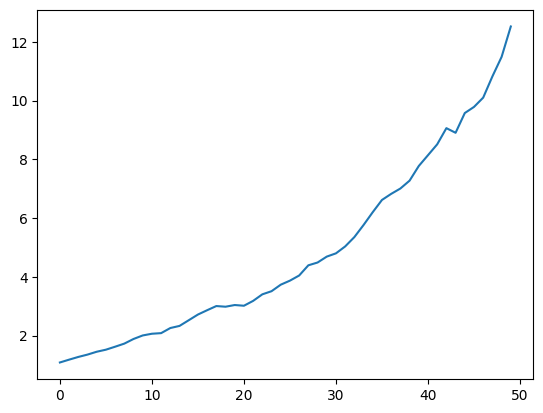

In [300]:
averaged_portfolio = portfolio.groupby("week").agg({"weighted_return":"mean","return":"mean"}).reset_index()
averaged_portfolio["pv"] = averaged_portfolio["return"].cumprod()
plt.plot(averaged_portfolio["pv"])
plt.show()